In [1]:
import torch
from torchvision import datasets, transforms
from PIL import Image
from torch.utils.data import Dataset,DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

import glob
import os
import zipfile

lr = 0.001
batch_size = 100
epochs= 5

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Download dogs-vs-cats.zip dataset from https://www.kaggle.com/competitions/dogs-vs-cats/data and save it in the current directory

In [3]:
# just check whats inside the folder
os.listdir()

['data',
 '.ipynb_checkpoints',
 'DogsVsCatsCNN.ipynb',
 'dogs-vs-cats.zip',
 'dogs_cats']

In [4]:
# Create a dogs_cats folder and extract the zipped dataset in this folder
os.makedirs('dogs_cats', exist_ok=True)
with zipfile.ZipFile('dogs-vs-cats.zip') as data:
    data.extractall('dogs_cats')

In [5]:
os.listdir("dogs_cats")

['test1.zip', 'sampleSubmission.csv', 'train.zip']

In [6]:
# the dogs_cats folder have train.zip and test.zip, lets unzip them from there to a folder 'data'
# the 'data' folder will have two folders now test1 and train each containing dogs and cats images
os.makedirs('data', exist_ok=True)
with zipfile.ZipFile('dogs_cats/train.zip') as train_zip:
    train_zip.extractall('data')

with zipfile.ZipFile('dogs_cats/test1.zip') as test_zip:
    test_zip.extractall('data')

In [7]:
# create varibles for trian and test directory path for easy use
train_dir = 'data/train'
test_dir = 'data/test1'

In [8]:
# Show some files in the train_dir just to see what in the directory
os.listdir(train_dir)[0:7]

['cat.8003.jpg',
 'cat.6113.jpg',
 'cat.11733.jpg',
 'dog.9490.jpg',
 'cat.2735.jpg',
 'cat.2467.jpg',
 'dog.8941.jpg']

In [9]:
# Use glob to find .jpg images only 
train_list = glob.glob(os.path.join(train_dir, '*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
print(train_list[3:5]) # just checking whats inside the train_list

['data/train/dog.9490.jpg', 'data/train/cat.2735.jpg']


## Use Sklearn to divide the data between train and validation

In [10]:
from sklearn.model_selection import train_test_split
train_split, val_split = train_test_split(train_list, test_size=0.25)

In [11]:
# get the lables from the Train data into a list train_labels
train_labels = []
val_labels = []
for x in train_split:
    train_labels.append(x.split('/')[-1].split('.')[0])

for x in val_split:
    val_labels.append(x.split('/')[-1].split('.')[0])
print(len(train_list), len(train_labels),len(val_labels), len(test_list)) # Checking lengths

25000 18750 6250 12500


## Show some random images from the training list

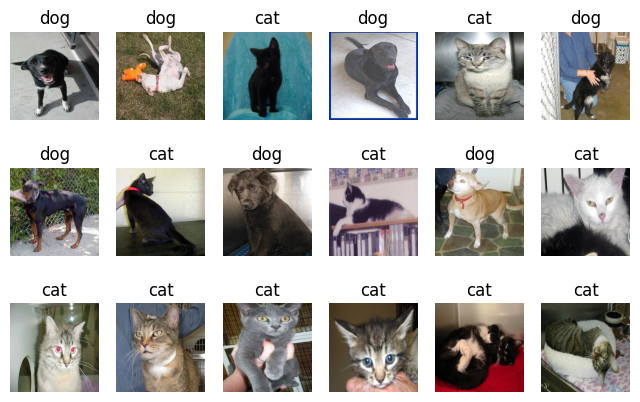

In [12]:
rand_ids = np.random.randint(1,len(train_split),18)
figure = plt.figure(figsize=(8,5))
i = 1
for id in rand_ids:
    img = Image.open(train_split[id])
    img = img.resize((224,224), Image.Resampling.LANCZOS)
    figure.add_subplot(3, 6, i)
    plt.title(train_labels[id])
    plt.axis('off')
    plt.imshow(img)
    i+=1
plt.show()

In [13]:
# Checking the sizes of few images in the data_set
print([Image.open(train_list[i]).size for i in range(5)])

[(431, 484), (400, 299), (499, 457), (499, 318), (499, 220)]


# Data Augmentation

In [14]:
data_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

## Creating and Dataset

In [15]:
class dataset(Dataset):
    def __init__(self, file_list, label_list, transform=None):
        self.file_list = file_list
        self.label_list = label_list
        self.transform = transform
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transform = self.transform(img)
        label = self.label_list[idx]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transform,label
    

In [16]:
train_data = dataset(train_split, train_labels, transform = data_transforms)
val_data = dataset(val_split, val_labels, transform = data_transforms)

train_loader = DataLoader(train_data,batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size = batch_size, shuffle=True)

## Creating a Model

In [17]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(3*3*64, 10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10, 2)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        #print(out.size())
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out
            
    

In [18]:
model = CNNModel().to(device)
model.train()
optimizer = torch.optim.Adam(params=model.parameters(), lr = lr)
loss_function = nn.CrossEntropyLoss()

## Just Checking size of the last layer passing a single image to the network

In [19]:
imageNorm = Image.open(train_list[5])
imageTensor = data_transforms(imageNorm)
imageTensor = imageTensor.to(device)
#print(imageTensor.size())

#checking if the model is Okay
imageTensor.unsqueeze_(0)
output = model(imageTensor)
print(output)
print(output.argmax())


tensor([[-0.0950,  0.4684]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(1, device='cuda:0')


## Create a Training Loop

In [20]:
def train(train_loader, model, loss_fn, optimizer):
    model.train()
    train_acc, train_loss = 0, 0 # train accuracy after one epoch
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        acc = ((output.argmax(dim=1) == label).float().mean())
        loss = loss_function(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # output lables of 100 images and compare witht the original labels get mean which is accuracy
        #print(output)

        train_acc += acc
        train_loss += loss
    train_acc = train_acc / len(train_loader)
    train_loss = train_loss / len(train_loader)
    print(f'Train Accuracy :{train_acc:.2f}%, train_loss: {train_loss:.2f}')

In [21]:
def test(test_loader, model, loss_fn):
    model.eval()
    test_acc, test_loss = 0, 0
    with torch.no_grad():
        for data, label in test_loader:
            data , label = data.to(device), label.to(device)
            output = model(data)
            acc = ((output.argmax(dim=1) == label).float().mean())
            loss = loss_function(output, label)
            # sum up the accuracy
            test_acc += acc
            test_loss += loss
    test_acc = test_acc/len(test_loader)
    test_loss = test_loss/ len(test_loader)
    print(f'Test Accuracy :{test_acc:.2f}%, Test_loss: {test_loss:.2f} \n')
        

In [22]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}-------------------------------")
    train(train_loader, model, loss_function, optimizer)
    test(val_loader, model, loss_function)
print("Done!")

Epoch 1-------------------------------
Train Accuracy :0.64%, train_loss: 0.63
Test Accuracy :0.63%, Test_loss: 0.66 

Epoch 2-------------------------------
Train Accuracy :0.70%, train_loss: 0.57
Test Accuracy :0.65%, Test_loss: 0.64 

Epoch 3-------------------------------
Train Accuracy :0.72%, train_loss: 0.54
Test Accuracy :0.72%, Test_loss: 0.53 

Epoch 4-------------------------------
Train Accuracy :0.74%, train_loss: 0.51
Test Accuracy :0.73%, Test_loss: 0.55 

Epoch 5-------------------------------
Train Accuracy :0.75%, train_loss: 0.50
Test Accuracy :0.69%, Test_loss: 0.58 

Epoch 6-------------------------------
Train Accuracy :0.75%, train_loss: 0.49
Test Accuracy :0.76%, Test_loss: 0.50 

Epoch 7-------------------------------
Train Accuracy :0.76%, train_loss: 0.48
Test Accuracy :0.73%, Test_loss: 0.55 

Epoch 8-------------------------------
Train Accuracy :0.77%, train_loss: 0.47
Test Accuracy :0.77%, Test_loss: 0.48 

Epoch 9-------------------------------
Train Acc

## Test and Show some images

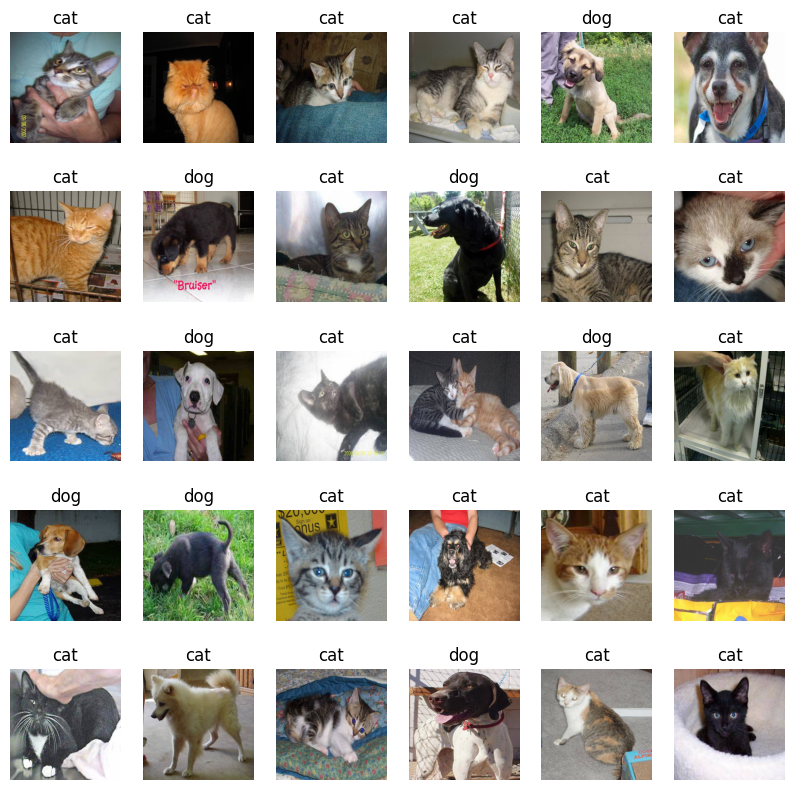

In [28]:
rand_ids = np.random.randint(1,len(test_list),30)
figure = plt.figure(figsize=(10,10))
i = 1
label = ''
model.eval()
with torch.no_grad():
    for id in rand_ids:
        img = Image.open(test_list[id])
        transformed = data_transforms(img)
        transformed = transformed.unsqueeze(0)
        transformed = transformed.to(device)
        predict = model(transformed)
        predict_class = torch.argmax(predict)
        if predict_class == 0:
            label = 'cat'
        elif predict_class ==1:
            label = 'dog'
        figure.add_subplot(5, 6, i)
        plt.title(label)
        plt.axis('off')
        img = img.resize((224,224), Image.Resampling.LANCZOS)
        plt.imshow(img)
        i+=1
plt.show()
            